In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import requests
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3,7)

It also requires Scikit-Learn >= 1.0.1:

In [3]:
from packaging import version

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Scrape the Data

In [11]:
seasonTypes = ['Regular%20Season', 'Playoffs']
years = ['2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2020-21','2020-21','2020-21']

initial_url = "https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=" + years[0] + "&SeasonType=" + seasonTypes[0] + "&StatCategory=PTS"
r = requests.get(url=initial_url).json()  # Define 'r' properly here


table_headers = r['resultSet']['headers']

df_col = ['Year', 'Season_type'] + table_headers
df = pd.DataFrame(columns=df_col)

for y in years:
        for s in seasonTypes:
                r = requests.get(url = "https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season="+y+"&SeasonType="+s+"&StatCategory=PTS").json()
                tempdf1 = pd.DataFrame(r['resultSet']['rowSet'], columns=table_headers)
                tempdf2 = pd.DataFrame({'Year':[y for i in range(len(tempdf1))],
                                        'Season_type':[s for i in range(len(tempdf1))]})
                tempdf3 = pd.concat([tempdf2,tempdf1], axis=1)
                df = pd.concat([df, tempdf3], axis=0)

# To export the DataSet for later use to avoid repeated scraping
dataPath = Path("datasets/nbaData.csv")

if not dataPath.exists():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        df.to_csv(Path('datasets/nbaData.csv'), index=False, sep=',')


/var/folders/l6/7q68j5tn4lvcn_tj4h3hc06c0000gn/T/ipykernel_22719/1913288240.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tempdf3], axis=0)


In [12]:
df = pd.read_csv('datasets/nbaData.csv')

## Data Cleaning

In [13]:
df.isna().sum() # Checks for 'Null' values

Year           0
Season_type    0
PLAYER_ID      0
RANK           0
PLAYER         0
TEAM_ID        0
TEAM           0
GP             0
MIN            0
FGM            0
FGA            0
FG_PCT         0
FG3M           0
FG3A           0
FG3_PCT        0
FTM            0
FTA            0
FT_PCT         0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
PTS            0
EFF            0
dtype: int64

In [14]:
df.drop(columns=['RANK','EFF'])

,Year,Season_type,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,...,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS
0,2012-13,Regular%20Season,2546,Carmelo Anthony,1610612752,NYK,67,37.0,10.0,22.2,...,7.6,0.830,2.0,4.9,6.9,2.6,0.8,0.5,2.6,28.7
1,2012-13,Regular%20Season,201142,Kevin Durant,1610612760,OKC,81,38.5,9.0,17.7,...,9.3,0.905,0.6,7.3,7.9,4.6,1.4,1.3,3.5,28.1
2,2012-13,Regular%20Season,977,Kobe Bryant,1610612747,LAL,78,38.6,9.5,20.4,...,8.0,0.839,0.8,4.7,5.6,6.0,1.4,0.3,3.7,27.3
3,2012-13,Regular%20Season,2544,LeBron James,1610612748,MIA,76,37.9,10.1,17.8,...,7.0,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,26.8
4,2012-13,Regular%20Season,201935,James Harden,1610612745,HOU,78,38.3,7.5,17.1,...,10.2,0.851,0.8,4.1,4.9,5.8,1.8,0.5,3.8,25.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,2020-21,Playoffs,203524,Solomon Hill,1610612737,ATL,14,10.4,0.4,1.7,...,0.3,0.500,0.2,1.1,1.4,0.2,0.1,0.1,0.1,1.2
3953,2020-21,Playoffs,1627885,Shaquille Harrison,1610612743,DEN,9,4.4,0.3,0.4,...,0.3,0.667,0.0,0.9,0.9,0.3,0.3,0.3,0.6,1.0
3954,2020-21,Playoffs,1630264,Anthony Gill,1610612764,WAS,4,8.3,0.0,0.8,...,0.0,0.000,0.3,0.8,1.0,0.0,0.0,0.0,0.8,0.0
3955,2020-21,Playoffs,1629067,Isaac Bonga,1610612764,WAS,4,2.5,0.0,1.3,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0


In [15]:
df['Season_Start_Year'] = df['Year'].str[:4].astype(int)

In [16]:
df['TEAM'] = df['TEAM'].replace(to_replace=['NOP','NOH'], value='NO')

In [17]:
df['Season_type'] = df['Season_type'].replace(to_replace=['Regular%20Season'], value=['RS'])

In [18]:
# To make a Regular Season and a Playoff Dataset
rs_df = df[df['Season_type']=='RS']
po_df = df[df['Season_type'] == 'Playoffs']

In [19]:
rs_df.describe()

,PLAYER_ID,RANK,TEAM_ID,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,Season_Start_Year
count,2.473000e+03,2473.000000,2.473000e+03,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,...,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000
mean,5.593720e+05,125.404367,1.610613e+09,69.891225,25.283623,4.210150,9.094420,0.464391,1.068621,2.931419,...,1.079458,3.507157,4.584674,2.478043,0.811120,0.505135,1.425879,11.355196,12.868257,2016.525273
std,6.492159e+05,73.333639,8.665557e+00,8.498471,6.801938,2.077707,4.354258,0.064310,0.872231,2.223040,...,0.854475,1.784206,2.469966,1.930575,0.393816,0.454813,0.786240,5.837837,5.963176,2.741320
min,4.670000e+02,1.000000,1.610613e+09,51.000000,4.900000,0.300000,0.800000,0.305000,0.000000,0.000000,...,0.100000,0.500000,0.700000,0.100000,0.100000,0.000000,0.100000,1.000000,1.300000,2012.000000
25%,2.015800e+05,62.000000,1.610613e+09,63.000000,19.600000,2.600000,5.800000,0.421000,0.300000,1.100000,...,0.500000,2.200000,2.800000,1.100000,0.500000,0.200000,0.800000,7.000000,8.600000,2014.000000
50%,2.030780e+05,124.000000,1.610613e+09,70.000000,25.600000,3.700000,8.200000,0.450000,1.000000,2.800000,...,0.800000,3.100000,4.000000,1.800000,0.700000,0.400000,1.200000,10.100000,11.600000,2016.000000
75%,1.626161e+06,186.000000,1.610613e+09,77.000000,31.100000,5.400000,11.700000,0.495000,1.600000,4.400000,...,1.500000,4.300000,5.800000,3.300000,1.000000,0.700000,1.800000,14.300000,15.900000,2020.000000
max,1.630267e+06,271.000000,1.610613e+09,83.000000,38.700000,11.200000,24.500000,0.763000,5.300000,13.200000,...,5.400000,11.100000,16.000000,11.700000,2.500000,3.700000,5.700000,36.100000,35.900000,2020.000000


In [20]:
df.columns

Index(['Year', 'Season_type', 'PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM',
       'GP', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PTS', 'EFF', 'Season_Start_Year'],
      dtype='object')

In [21]:
total_cols = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM','FTA',
              'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV','PTS']

## PLAYER STAT CORRELATIONS

In [22]:
data_per_min = df.groupby(['PLAYER', 'PLAYER_ID', 'Year'])[total_cols].sum().reset_index()
data_per_min.columns
for col in data_per_min.columns[4:]:
     data_per_min[col] = data_per_min[col] / data_per_min['MIN']

data_per_min['FG%'] = data_per_min['FGM']/data_per_min['FGA'] 
data_per_min['FG3%'] = data_per_min['FG3M']/data_per_min['FG3A']
data_per_min['FT%'] = data_per_min['FTM']/data_per_min['FTA']
data_per_min['FG3A%'] = data_per_min['FG3A']/data_per_min['FGA']
data_per_min['PTS/FGA'] = data_per_min['PTS']/data_per_min['FGA']
data_per_min['FG3M/FGM'] = data_per_min['FG3M']/data_per_min['FGM']
data_per_min['FTA/FGA'] = data_per_min['FTA']/data_per_min['FGA']
data_per_min['TRU%'] = 0.5*data_per_min['PTS']/(data_per_min['FGA']+0.475*data_per_min['FTA'])
data_per_min['AST_TOV'] = data_per_min['AST']/data_per_min['TOV']

data_per_min = data_per_min.drop(columns='PLAYER_ID')
data_per_min = data_per_min[data_per_min['MIN'] >= 50]

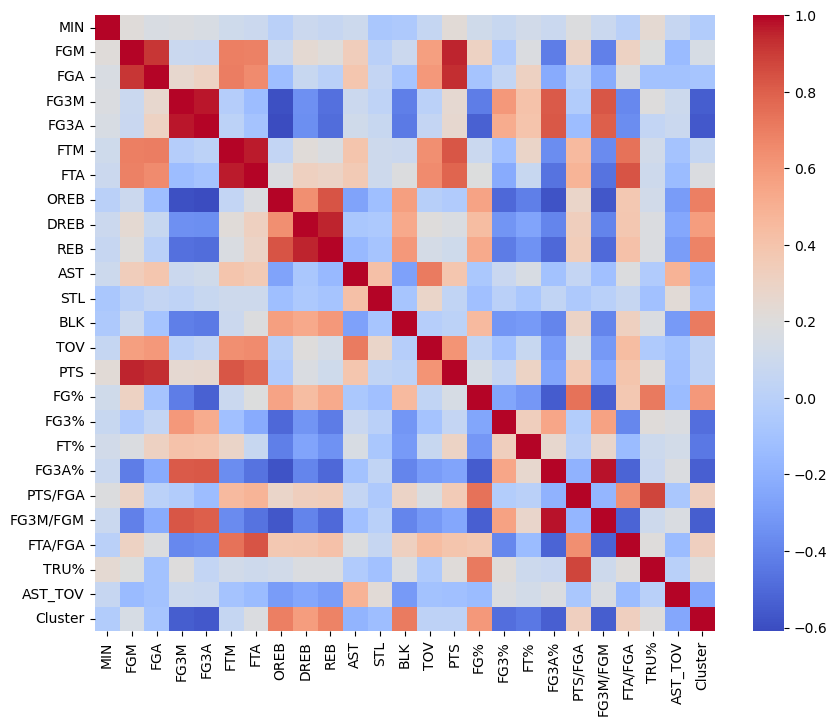

In [30]:
data_per_min2 = data_per_min.drop(columns=['Year', 'PLAYER'])
correlation_matrix = data_per_min2.corr()
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap = 'coolwarm')
plt.show()

<Axes: xlabel='MIN', ylabel='Count'>

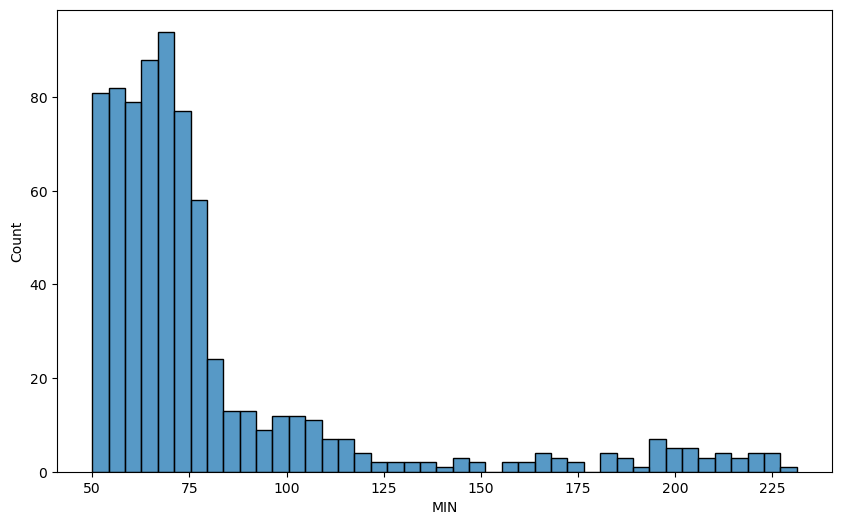

In [24]:
player_counts = data_per_min['PLAYER'].value_counts()
plt.figure(figsize=(10,6))

sns.histplot(data=data_per_min, x=data_per_min['MIN'])

Cluster Centers:
        PTS       AST       REB       BLK       STL       TOV       FG%  \
0  0.462938  0.107911  0.142113  0.012173  0.032831  0.055457  0.435962   
1  0.469790  0.081894  0.258605  0.038115  0.029114  0.056543  0.517373   

       FG3%       FT%  
0  0.360912  0.808189  
1  0.243526  0.697781  


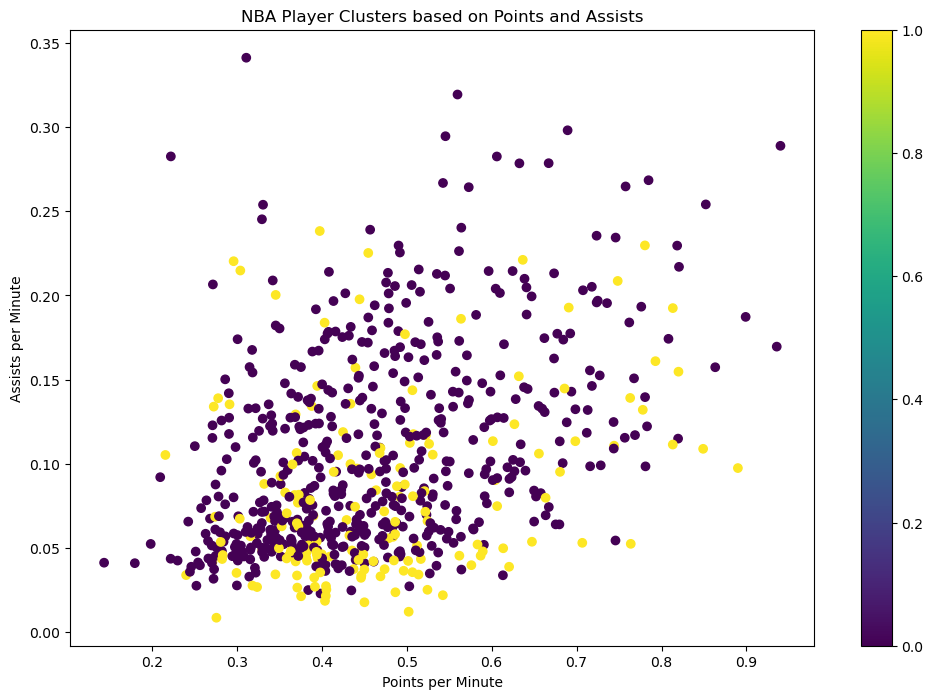


Top 5 players in Cluster 0:
              PLAYER    MIN       PTS       AST       REB       BLK       STL  \
373   Damian Lillard  231.3  0.818418  0.229572  0.110246  0.012970  0.024643   
203     Bradley Beal  224.4  0.819519  0.114973  0.145722  0.013369  0.026738   
1703     Paul George  223.5  0.673826  0.142282  0.217450  0.012081  0.028188   
1364     Luka Doncic  223.2  0.852151  0.254032  0.213710  0.012097  0.030914   
522     Devin Booker  222.9  0.711978  0.118439  0.131898  0.005384  0.021534   

           TOV       FG%      FG3%       FT%  
373   0.067445  0.457346  0.421277  0.935484  
203   0.094920  0.470588  0.285714  0.872483  
1703  0.091275  0.453083  0.375796  0.853659  
1364  0.119624  0.484536  0.380208  0.631944  
522   0.091521  0.464373  0.333333  0.880952  

Top 5 players in Cluster 1:
                     PLAYER    MIN       PTS       AST       REB       BLK  \
726   Giannis Antetokounmpo  213.3  0.819972  0.154712  0.334740  0.033755   
1607           Ni

In [28]:
features = ['PTS', 'AST', 'REB', 'BLK', 'STL', 'TOV', 'FG%', 'FG3%', 'FT%']

# Prepare the data
X = data_per_min[features]

# Drop rows with NaN values
X = X.dropna()

# Ensure data_per_min has the same number of rows as X
data_per_min = data_per_min.loc[X.index]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using silhouette score
max_clusters = 10
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Fit K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_per_min['Cluster'] = kmeans.fit_predict(X_scaled)

# Print cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("Cluster Centers:")
print(cluster_centers_df)

# Visualize clusters (example using PTS and AST)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_per_min['PTS'], data_per_min['AST'], c=data_per_min['Cluster'], cmap='viridis')
plt.xlabel('Points per Minute')
plt.ylabel('Assists per Minute')
plt.title('NBA Player Clusters based on Points and Assists')
plt.colorbar(scatter)
plt.show()

for i in range(optimal_clusters):
    print(f"\nTop 5 players in Cluster {i}:")
    cluster_players = data_per_min[data_per_min['Cluster'] == i].sort_values('MIN', ascending=False)
    print(cluster_players[['PLAYER', 'MIN'] + features].head())
